In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

import wget

import matplotlib.pyplot as plt
import librosa.display

import zipfile
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from io import TextIOWrapper

from tqdm import tqdm
import requests


from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from scipy.signal import hilbert


import random
from scipy.signal import fftconvolve

from scipy.signal import hilbert
import numpy as np
import librosa
from tqdm import tqdm

In [3]:
# ----------------------------------------------------------------------------------
# FUNCTIONS
# ----------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------
# DATASET IMPORT, EXTRACTION, ANALYSIS
# ----------------------------------------------------------------------------------

def extract_zip_if_needed(zip_path, extract_to=None):
    """
    Estrae il file ZIP se la cartella di destinazione non esiste già.

    Args:
        zip_path (str): Percorso al file ZIP
        extract_to (str, optional): Cartella dove estrarre i file. Se None, usa il nome del file ZIP.

    Returns:
        str: Percorso alla cartella estratta
    """

    # Se la directory di estrazione non è specificata, usa il nome del file ZIP
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]

    # Controlla se la directory di estrazione esiste già
    if os.path.exists(extract_to) and os.path.isdir(extract_to):
        print(f"La directory '{extract_to}' esiste già, l'estrazione verrà saltata.")
        return extract_to

    # Estrai lo ZIP se esiste
    if os.path.exists(zip_path):
        print(f"Estrazione di '{zip_path}' in '{extract_to}'...")

        # Ottieni la lista dei file nello ZIP per la progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            total_files = len(file_list)

        # Estrai i file con progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            os.makedirs(extract_to, exist_ok=True)
            for file in tqdm(file_list, desc="Estrazione files", total=total_files):
                zip_ref.extract(file, extract_to)

        print(f"Estrazione completata in '{extract_to}'")
    else:
        raise FileNotFoundError(f"Il file ZIP '{zip_path}' non esiste.")

    return extract_to



def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """

    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset

def analyze_audio_channels(file_list):
    """
    Analizza il numero di canali audio nei file del database.

    Args:
        file_list: Lista di percorsi ai file audio

    Returns:
        tuple: (conteggio_stereo, conteggio_mono, dettagli_per_file)
    """
    mono_count = 0
    stereo_count = 0
    file_details = []

    # Loop attraverso tutti i file con progress bar
    for file_path in tqdm(file_list, desc="Analisi file audio"):
        try:
            # Carica il file preservando i canali
            y, sr = librosa.load(file_path, sr=None, mono=False)

            # Controlla se è mono o stereo
            if y.ndim == 1:  # Mono (1 dimensione)
                mono_count += 1
                channels = 1
            else:  # Stereo (2 dimensioni)
                stereo_count += 1
                channels = y.shape[0]

            # Aggiungi dettagli
            file_name = os.path.basename(file_path)
            file_details.append({
                'file': file_name,
                'channels': channels,
                'tipo': 'mono' if channels == 1 else 'stereo'
            })

        except Exception as e:
            print(f"Errore nell'analisi del file {file_path}: {e}")

    return stereo_count, mono_count, file_details


# ----------------------------------------------------------------------
# DATA AUGMENTATION
# ----------------------------------------------------------------------

# 1. Rumore
def add_noise(y, snr_db=10):
    signal_power = np.mean(y**2)
    snr = 10**(snr_db / 10)
    noise_power = signal_power / snr
    noise = np.random.normal(0, np.sqrt(noise_power), size=y.shape)
    return y + noise

# 2. Pitch shift

def apply_pitch_shift(y, sr):
    is_stereo = y.ndim > 1
    
    if is_stereo:
        # Gestione stereo (separatamente per ogni canale)
        ch1 = librosa.effects.pitch_shift(y[0], sr=sr, n_steps=2)
        ch2 = librosa.effects.pitch_shift(y[1], sr=sr, n_steps=2)
        
        # Ricombina i canali
        return np.array([ch1, ch2])
    else:
        # Caso mono originale
        return librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

# 3. Time stretch

def apply_time_stretch(y, rate=1.2):
    is_stereo = y.ndim > 1
    
    if is_stereo:
        # Gestione stereo (separatamente per ogni canale)
        ch1 = librosa.effects.time_stretch(y[0], rate=rate)
        ch2 = librosa.effects.time_stretch(y[1], rate=rate)
        
        if len(ch1) > len(y[0]):
            ch1 = ch1[:len(y[0])]
        elif len(ch1) < len(y[0]):
            ch1= np.pad(ch1, (0, len(y[0])-len(ch1)), mode='constant', constant_values=(0,0))

        if len(ch2) > len(y[1]):
            ch2 = ch2[:len(y[1])]
        elif len(ch2) < len(y[1]):
            ch2 = np.pad(ch2, (0, len(y[1])-len(ch2)), mode='constant', constant_values=(0,0))
        
        # print(len(y[0]))
        # print(len(y[1]))
        # print(len(ch1))
        # print(len(ch2))

        return np.array([ch1, ch2])
    else:
        # Caso mono originale
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        if len(y_stretched) > len(y):
            return y_stretched[:len(y)]
        else:
            return np.pad(y_stretched, (0, len(y) - len(y_stretched)), mode='constant')

'''
def apply_random_crop(y, sr, target_duration=2.0):
    # Rileva se l'audio è stereo o mono
    is_stereo = y.ndim > 1
    
    # Ottiene il numero di campioni correttamente
    if is_stereo:
        n_samples = len(y[0])  # Per audio stereo
    else:
        n_samples = len(y)      # Per audio mono
    
    # Calcola parametri di crop
    crop_duration = random.uniform(0.5, target_duration - 0.01)
    crop_length = np.floor(crop_duration * sr)
    target_length = np.floor(target_duration * sr)
    
    # Gestisce il caso in cui l'audio è più corto della lunghezza di crop
    if n_samples <= crop_length:
        y_crop = y
    else:
        start = np.random.randint(0, n_samples - crop_length)
        if is_stereo:
            y_crop = y[:, start:start + crop_length]  # Slice per stereo
        else:
            y_crop = y[start:start + crop_length]     # Slice per mono
    
    # Padding alla lunghezza target
    if is_stereo:
        crop_samples = y_crop.shape[1]
        y_padded = np.pad(y_crop, ((0, 0), (0, target_length - crop_samples)), mode='constant')
    else:
        y_padded = np.pad(y_crop, (0, target_length - len(y_crop)), mode='constant')
    
    print(len(y[0]))
    print(len(y[1]))
    print(len(y_padded[0]))
    print(len(y_padded[1]))
    
    return y_padded
'''

# Lista delle augmentazioni disponibili
AUGMENTATION_FUNCTIONS = [
    apply_pitch_shift,
    apply_time_stretch,
    add_noise,
    # apply_random_crop
]

# Funzione principale di augmentazione
def augment_audio(y, sr, n_augmentations=2):
    """
    Applica n_augmentations funzioni di augmentation casuali all'audio.
    
    Args:
        y: array audio di input (stereo o mono)
        sr: sample rate
        n_augmentations: numero di augmentations da applicare in sequenza
    
    Returns:
        array audio modificato nello stesso formato dell'input
    """
    # Seleziona n_augmentations funzioni casuali dalla lista disponibile
    selected_augs = random.sample(AUGMENTATION_FUNCTIONS, k=n_augmentations)
    
    # Audio da modificare (inizialmente l'originale)
    y_aug = y.copy()
    
    # Applica le augmentations in sequenza
    for aug_fn in selected_augs:
        args = aug_fn.__code__.co_varnames
        if 'sr' in args and 'target_duration' in args:
            y_aug = aug_fn(y_aug, sr, target_duration=2.0)
        elif 'sr' in args:
            y_aug = aug_fn(y_aug, sr)
        else:
            y_aug = aug_fn(y_aug)
    
    return y_aug


# ----------------------------------------------------------------------------------
# FEATURE EXTRACTION
# ----------------------------------------------------------------------------------

def normalize_spectrogram(spec):
    spec_min = np.min(spec)
    spec_max = np.max(spec)
    return (spec - spec_min) / (spec_max - spec_min + 1e-6)

def compute_ild_ipd(left, right):
    """
    Calcola ILD e IPD da due canali separati.
    """
    eps = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        ild = 20 * np.log10(np.abs(left) / (np.abs(right) + eps))
        ild[np.isinf(ild)] = 0  # sostituisci inf con 0
    
    analytic_left = hilbert(left)
    analytic_right = hilbert(right)
    phase_left = np.angle(analytic_left)
    phase_right = np.angle(analytic_right)
    ipd = phase_left - phase_right
    ipd = (ipd + np.pi) % (2 * np.pi) - np.pi
    
    ild_stats = np.array([np.mean(ild), np.std(ild), np.max(ild), np.median(ild)])
    ipd_stats = np.array([np.mean(ipd), np.std(ipd), np.max(ipd), np.median(ipd)])
    
    return ild_stats, ipd_stats



def extract_stats(feature):
    # First calculate statistics across the time/feature dimension (axis=2)
    mean_val = np.mean(feature, axis=2)
    std_val = np.std(feature, axis=2)
    max_val = np.max(feature, axis=2)
    median_val = np.median(feature, axis=2)
    
    # Reshape to remove the middle dimension of 1 and stack the statistics along a new dimension
    # This will result in shape (17506, 4)
    return np.column_stack([
        mean_val.reshape(-1),
        std_val.reshape(-1),
        max_val.reshape(-1),
        median_val.reshape(-1)
    ])


# ----------------------------------------------------------------------------------
# PLOTS
# ----------------------------------------------------------------------------------

def plot_single_output_model(history, y_true, y_pred, class_names=None):
    """
    Visualizza le metriche di addestramento e genera il classification report
    per un modello con singolo output usando predizioni pre-calcolate.
    
    Args:
        history: Oggetto history restituito da model.fit()
        y_true: Label vere (indici di classe, non one-hot encoded)
        y_pred: Predizioni del modello (indici di classe, non one-hot encoded)
        class_names: Lista con i nomi delle classi (opzionale)
    """
    
    # Crea una figura per i grafici di accuracy e loss
    plt.figure(figsize=(12, 5))
    
    # Grafico per l'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Grafico per la loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Trova e stampa la migliore accuracy
    best_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_acc) + 1
    
    print(f"Miglior accuracy: {best_acc:.4f} (epoch {best_epoch})")
    
    # Se non sono forniti i nomi delle classi, usa etichette numeriche
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]
    
    # Genera e stampa il classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Visualizza la matrice di confusione
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_vehicle_test_results(vehicle_true, vehicle_pred, vehicle_class_names, test_results=None):
    """
    Visualizza e valuta i risultati di test per un modello con singolo output (veicolo).
    
    Args:
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        test_results: Tupla con (loss, accuracy) dalla valutazione del modello (opzionale)
    """
    
    # ----- STATISTICHE DI PRESTAZIONE -----
    
    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")
    
    # Accuratezza veicoli
    vehicle_accuracy = np.mean(vehicle_true == vehicle_pred)
    print(f"Vehicle accuracy: {vehicle_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Test loss: {test_results[0]:.4f}")
        print(f"Test accuracy: {test_results[1]:.4f}")
    
    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))
    
    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 10))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Balanced accuracy
    bal_acc = balanced_accuracy_score(vehicle_true, vehicle_pred)
    print(f"\nBalanced accuracy score: {bal_acc:.4f}")

def plot_direction_test_results(direction_true, direction_pred, direction_class_names, test_results=None):
    """
    Visualizza e valuta i risultati di test per un modello con singolo output (direzione).
    
    Args:
        direction_true: Label vere delle direzioni (indici di classe)
        direction_pred: Predizioni del modello per direzioni (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
        test_results: Tupla con (loss, accuracy) dalla valutazione del modello (opzionale)
    """
    
    # ----- STATISTICHE DI PRESTAZIONE -----
    
    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONI =====")
    
    # Accuratezza direzioni
    direction_accuracy = np.mean(direction_true == direction_pred)
    print(f"Direction accuracy: {direction_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Test loss: {test_results[0]:.4f}")
        print(f"Test accuracy: {test_results[1]:.4f}")
    
    # Classification report direzioni
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))
    
    # Matrice di confusione direzioni
    plt.figure(figsize=(12, 10))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Balanced accuracy
    bal_acc = balanced_accuracy_score(direction_true, direction_pred)
    print(f"\nBalanced accuracy score: {bal_acc:.4f}")

    
def plot_and_evaluate_multi_output_model(history,
                                         vehicle_true, vehicle_pred, vehicle_class_names,
                                         direction_true, direction_pred, direction_class_names):
    """
    Visualizza le metriche di addestramento e genera i classification report
    per un modello con doppio output (veicolo e direzione).

    Args:
        history: Oggetto history restituito da model.fit()
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        direction_true: Label vere di direzione (indici di classe)
        direction_pred: Predizioni del modello per direzione (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
    """

    # ----- METRICHE DI TRAINING -----

    # Crea una figura per i grafici di accuracy e loss
    plt.figure(figsize=(15, 10))

    # Grafico accuratezza veicoli
    plt.subplot(2, 2, 1)
    plt.plot(history.history['vehicle_output_accuracy'], label='Train Vehicle Accuracy')
    plt.plot(history.history['val_vehicle_output_accuracy'], label='Validation Vehicle Accuracy')
    plt.title('Vehicle Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafico loss veicoli
    plt.subplot(2, 2, 2)
    plt.plot(history.history['vehicle_output_loss'], label='Train Vehicle Loss')
    plt.plot(history.history['val_vehicle_output_loss'], label='Validation Vehicle Loss')
    plt.title('Vehicle Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Grafico accuratezza direzione
    plt.subplot(2, 2, 3)
    plt.plot(history.history['direction_output_accuracy'], label='Train Direction Accuracy')
    plt.plot(history.history['val_direction_output_accuracy'], label='Validation Direction Accuracy')
    plt.title('Direction Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafico loss direzione
    plt.subplot(2, 2, 4)
    plt.plot(history.history['direction_output_loss'], label='Train Direction Loss')
    plt.plot(history.history['val_direction_output_loss'], label='Validation Direction Loss')
    plt.title('Direction Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ----- STATISTICHE DI PRESTAZIONE -----

    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")

    # Trova e stampa la migliore accuracy per veicoli
    best_vehicle_acc = max(history.history['val_vehicle_output_accuracy'])
    best_vehicle_epoch = history.history['val_vehicle_output_accuracy'].index(best_vehicle_acc) + 1
    print(f"Miglior vehicle accuracy: {best_vehicle_acc:.4f} (epoch {best_vehicle_epoch})")

    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))

    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONE =====")

    # Trova e stampa la migliore accuracy per direzione
    best_direction_acc = max(history.history['val_direction_output_accuracy'])
    best_direction_epoch = history.history['val_direction_output_accuracy'].index(best_direction_acc) + 1
    print(f"Miglior direction accuracy: {best_direction_acc:.4f} (epoch {best_direction_epoch})")

    # Classification report direzione
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))

    # Matrice di confusione direzione
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()



def plot_test_results_multi_output_model(vehicle_true, vehicle_pred, vehicle_class_names,
                     direction_true, direction_pred, direction_class_names,
                     test_results=None):
    """
    Visualizza e valuta i risultati di test per un modello con doppio output.
    
    Args:
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        direction_true: Label vere di direzione (indici di classe)
        direction_pred: Predizioni del modello per direzione (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
        test_results: Risultati della valutazione del modello (opzionale)
    """
    
    # ----- STATISTICHE DI PRESTAZIONE -----
    
    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")
    
    # Accuratezza veicoli
    vehicle_accuracy = np.mean(vehicle_true == vehicle_pred)
    print(f"Vehicle accuracy: {vehicle_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Vehicle loss: {test_results[1]:.4f}")
    
    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))
    
    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONE =====")
    
    # Accuratezza direzione
    direction_accuracy = np.mean(direction_true == direction_pred)
    print(f"Direction accuracy: {direction_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Direction loss: {test_results[2]:.4f}")
    
    # Classification report direzione
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))
    
    # Matrice di confusione direzione
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [4]:
# ------------------------------------------------------------------------------------
# IMPORT DATASET AND ANALYSIS
# ------------------------------------------------------------------------------------


# Percorso assoluto del file ZIP
# ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip" # di Stefano
ZIP_PATH = "IDMT_Traffic.zip"
# AUDIO_DIR = "IDMT_Traffic/audio/"
# ANN_DIR = "IDMT_Traffic/annotation/idmt_traffic_all.txt"

# Download file if it doesn't exist
if not os.path.exists(ZIP_PATH):
    url = "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
    print(f"Downloading {ZIP_PATH}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(ZIP_PATH, 'wb') as file:
        with tqdm(
                desc=ZIP_PATH,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
    print("Download complete!")
else:
    print(f"File {ZIP_PATH} already exists, skipping download.")


# Estrai lo ZIP se necessario
extracted_dir = extract_zip_if_needed(ZIP_PATH)

AUDIO_DIR_PATH = os.path.join(extracted_dir, "IDMT_Traffic/audio/")
ANN_FILE_PATH = os.path.join(extracted_dir, "IDMT_Traffic/annotation/idmt_traffic_all.txt")

all_audio_files = [os.path.join(AUDIO_DIR_PATH, f) for f in os.listdir(AUDIO_DIR_PATH) if f.endswith('.wav')]
print(f"\nNumero totale di file audio trovati: {len(all_audio_files)}")

# Leggi il file di annotazione
# df_dataset = pd.read_csv(ANN_FILE_PATH, sep="\t", header=None)
df_dataset = import_idmt_traffic_dataset(ANN_FILE_PATH)
vehicle = df_dataset["vehicle"]
direction = df_dataset["source_direction"]
print(np.unique(vehicle))
print(np.unique(direction))


# LABEL ENCODING
# Use separate encoders for different label types
le_vehicle = LabelEncoder()
labels_encoded_vehicle = le_vehicle.fit_transform(vehicle)
labels_cat_vehicles = to_categorical(labels_encoded_vehicle)

le_direction = LabelEncoder()
labels_encoded_direction = le_direction.fit_transform(direction)
labels_cat_direction = to_categorical(labels_encoded_direction)

# Esegui l'analisi
stereo_count, mono_count, details = analyze_audio_channels(all_audio_files)

# Stampa i risultati
print("\n------ ANALISI CANALI AUDIO ------")
print(f"Numero di file stereo: {stereo_count}")
print(f"Numero di file mono: {mono_count}")
print(f"Totale file analizzati: {stereo_count + mono_count}")
print(f"Percentuale stereo: {stereo_count/(stereo_count + mono_count)*100:.1f}%")
print(f"Percentuale mono: {mono_count/(stereo_count + mono_count)*100:.1f}%")

df_details = pd.DataFrame(details)
print("\nPrimi 5 file analizzati:")
print(df_details.head())

File IDMT_Traffic.zip already exists, skipping download.
La directory 'IDMT_Traffic' esiste già, l'estrazione verrà saltata.

Numero totale di file audio trovati: 17506
['B' 'C' 'M' 'None' 'T']
['L' 'None' 'R']


Analisi file audio: 100%|██████████| 17506/17506 [03:15<00:00, 89.49it/s] 


------ ANALISI CANALI AUDIO ------
Numero di file stereo: 17506
Numero di file mono: 0
Totale file analizzati: 17506
Percentuale stereo: 100.0%
Percentuale mono: 0.0%

Primi 5 file analizzati:
                                                file  channels    tipo
0  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...         2  stereo
1  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...         2  stereo
2  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...         2  stereo
3  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...         2  stereo
4  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...         2  stereo


In [5]:
# -------------------------------------------------------------------------------------
# FEATURE EXTRACTION
# -------------------------------------------------------------------------------------

spectrograms = []
spectral_centroids = []
spectral_rolloffs = []
spectral_contrasts = []
low_freq_energies = []
fixed_length = None

ild_features = []
ipd_features = []


# --- Parametri comuni ---
n_fft = 2048
hop_length = 512
n_mels = 128


file_counter = 0
for audio_path in all_audio_files[:]:

    y, sr = librosa.load(audio_path, sr=None, mono=False)

    file_counter += 1

    # Augment 1 sample every 10
    if file_counter % 10 == 0:
        y = augment_audio(y, sr, n_augmentations=1)
    
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


    # 1 centroide per ogni frame
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # 1 rolloff per ogni frame
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # 1 contrasto per banda (default 6+1 bande)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    low_freq_energy = np.sum(mel_spectrogram[:10, :]) / (np.sum(mel_spectrogram) + 1e-10)

    if fixed_length is None:
        fixed_length = mel_spectrogram_db.shape[1]
    
    # Padding o troncamento
    if mel_spectrogram_db.shape[1] < fixed_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db,
                                    ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])),
                                    mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]
    
    # Normalizzazione
    mel_spectrogram_db = normalize_spectrogram(mel_spectrogram_db)
    
    spectrograms.append(mel_spectrogram_db) 
    spectral_centroids.append(spectral_centroid)
    spectral_rolloffs.append(spectral_rolloff)
    spectral_contrasts.append(spectral_contrast)
    low_freq_energies.append(low_freq_energy)      

    # ILD/IPD stats
    ild_stats, ipd_stats = compute_ild_ipd(y[0], y[1])  # Assuming stereo audio
    ild_features.append(ild_stats)
    ipd_features.append(ipd_stats)


spectrograms = np.array(spectrograms)
spectrograms = spectrograms / np.max(np.abs(spectrograms))

spectral_centroids = np.array(spectral_centroids)
spectral_rolloffs = np.array(spectral_rolloffs)
spectral_contrasts = np.array(spectral_contrasts)
low_freq_energies = np.array(low_freq_energies)

ild_features = np.array(ild_features)
ipd_features = np.array(ipd_features)

input_shape = spectrograms.shape[1:]

print("Spectrograms shape:", spectrograms.shape)
print("Spectral Centroids shape:", spectral_centroids.shape)
print("Spectral Rolloffs shape:", spectral_rolloffs.shape)
print("Spectral Contrasts shape:", spectral_contrasts.shape)
print("Low freq energies shape:", low_freq_energies.shape)
print("ILD features shape:", ild_features.shape)
print("IPD features shape:", ipd_features.shape)
print("Input shape for model:", input_shape)


# Statistics from the features -------------

centroid_stats = extract_stats(spectral_centroids)  # (17506, 4)
rolloff_stats = extract_stats(spectral_rolloffs)    # (17506, 4) 
contrast_stats_left = extract_stats(spectral_contrasts[:, :spectral_contrasts.shape[1] // 2, :])  # Left channel
contrast_stats_right = extract_stats(spectral_contrasts[:, spectral_contrasts.shape[1] // 2:, :])  # Right channel

print(f"Centroid stats shape: {centroid_stats.shape}")
print(f"Rolloff stats shape: {rolloff_stats.shape}")
print(f"Contrast stats shape (left): {contrast_stats_left.shape}")
print(f"Contrast stats shape (right): {contrast_stats_right.shape}")
print(f"Low frequency energies shape: {low_freq_energies.shape}")
print(f"ILD features shape: {ild_features.shape}")
print(f"IPD features shape: {ipd_features.shape}")

audio_features = np.concatenate([
    centroid_stats,                     # (17506, 4)
    rolloff_stats,                      # (17506, 4) 
    contrast_stats_left,                # (17506, 4)
    contrast_stats_right,               # (17506, 4)
    low_freq_energies.reshape(-1, 1)   # (17506, 1)
], axis=1)  # Risultato: (17506, 17)

direction_features = np.concatenate([
    ild_features,                       # (17506, 4)
    ipd_features                        # (17506, 4) 
], axis=1)  # Risultato: (17506, 8)

# "Cleaning"
audio_features = np.nan_to_num(audio_features, nan=0.0, posinf=0.0, neginf=0.0)
direction_features = np.nan_to_num(direction_features, nan=0.0, posinf=0.0, neginf=0.0)

# Normalize
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(audio_features)
direction_features_scaled = scaler.fit_transform(direction_features)

print()
print(audio_features_scaled.shape)
print(direction_features_scaled.shape)

Spectrograms shape: (17506, 2, 128, 188)
Spectral Centroids shape: (17506, 1, 188)
Spectral Rolloffs shape: (17506, 1, 188)
Spectral Contrasts shape: (17506, 2, 188)
Low freq energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)
Input shape for model: (2, 128, 188)
Centroid stats shape: (17506, 4)
Rolloff stats shape: (17506, 4)
Contrast stats shape (left): (17506, 4)
Contrast stats shape (right): (17506, 4)
Low frequency energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)

(17506, 17)
(17506, 8)


In [6]:
# ------------------------------------------------------------------------------
# DATASET SPLIT
# ------------------------------------------------------------------------------

print(f"Dimensione spettrogrammi prima del reshape: {spectrograms.shape}")
# spectrograms_reshaped = spectrograms.reshape(spectrograms.shape[0], spectrograms.shape[1], spectrograms.shape[2], 1)
spectrograms_reshaped = spectrograms.transpose(0, 2, 3, 1)  # (17506, 128, 188, 2)
print(f"Dimensione spettrogrammi dopo il reshape: {spectrograms_reshaped.shape}")

# 1. Primo split: Train (70%) e Temporary (30%)
X_train, X_temp, audio_features_train, audio_features_temp, direction_features_train, direction_features_temp, y_train_vehicle, y_temp_vehicle, y_train_direction, y_temp_direction = train_test_split(
    spectrograms_reshaped,
    audio_features_scaled,
    direction_features_scaled,
    labels_cat_vehicles,
    labels_cat_direction,
    test_size=0.30,         # 70% train, 30% temporary
    random_state=42,
    shuffle=True
)

# 2. Secondo split: Temporary in Validation (15%) e Test (15%)
X_val, X_test, audio_features_val, audio_features_test, direction_features_val, direction_features_test, y_val_vehicle, y_test_vehicle, y_val_direction, y_test_direction = train_test_split(
    X_temp,
    audio_features_temp,
    direction_features_temp,
    y_temp_vehicle,
    y_temp_direction,
    test_size=0.50,        # 15% validation, 15% test (metà del 30% temporary)
    random_state=42,
    shuffle=True
)

print()
print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")

# Verifica dimensioni input per il modello
print(f"Dimensione input spettrogrammi: {X_train.shape[1:]}")
print(f"Dimensione input feature audio: {audio_features_train.shape[1:]}")
print(f"Dimensione input feature direzione: {direction_features_train.shape[1:]}")

Dimensione spettrogrammi prima del reshape: (17506, 2, 128, 188)
Dimensione spettrogrammi dopo il reshape: (17506, 128, 188, 2)

Train set: 12254 campioni
Validation set: 2626 campioni
Test set: 2626 campioni
Dimensione input spettrogrammi: (128, 188, 2)
Dimensione input feature audio: (17,)
Dimensione input feature direzione: (8,)


In [7]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 13
# ------------------------------------------------------------------------------

'''
PARTE VEICOLI

Come modello 9 ma con data aug
'''

# Definizione del modello

# 1. Ramo CNN per spettrogrammi
input_spectrogram = tf.keras.Input(shape=spectrograms_reshaped.shape[1:], name='spectrogram_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_spectrogram)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)


# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.2)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)

# Fusione dei due rami
merged = tf.keras.layers.Concatenate()([x1, x2])

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

output = tf.keras.layers.Dense(5, activation='softmax')(x)

# Modello completo
model_13 = tf.keras.Model(inputs=[input_spectrogram, input_features], outputs=output)

model_13.summary()


model_13.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_vehicle_output_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_13.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 128, 188,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 186,  │      1,216 │ spectrogram_inpu… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 93,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 93,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 91,    │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 45,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 45,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 43,    │     18,464 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 21,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,152 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14, 21,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 19,    │      4,624 │ dropout_2[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 9, 16)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 6, 9, 16)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,578,261 (6.02 MB)

 Trainable params: 1,578,261 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history_13 = model_13.fit(
    [X_train, audio_features_train],  # inputs
    y_train_vehicle,                  # target
    epochs=500,
    batch_size=32,
    validation_data=([X_val, audio_features_val], y_val_vehicle),
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7657 - loss: 0.6755

c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_vehicle_output_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


383/383 ━━━━━━━━━━━━━━━━━━━━ 67s 156ms/step - accuracy: 0.7659 - loss: 0.6751 - val_accuracy: 0.8637 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 2/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8850 - loss: 0.3830

383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - accuracy: 0.8850 - loss: 0.3830 - val_accuracy: 0.8797 - val_loss: 0.4472 - learning_rate: 0.0010
Epoch 3/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9038 - loss: 0.3112

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - accuracy: 0.9038 - loss: 0.3112 - val_accuracy: 0.9078 - val_loss: 0.2904 - learning_rate: 0.0010
Epoch 4/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9054 - loss: 0.2980

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9054 - loss: 0.2979 - val_accuracy: 0.9124 - val_loss: 0.2818 - learning_rate: 0.0010
Epoch 5/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9061 - loss: 0.2956 - val_accuracy: 0.9067 - val_loss: 0.3161 - learning_rate: 0.0010
Epoch 6/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9082 - loss: 0.2719

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.9082 - loss: 0.2719 - val_accuracy: 0.9196 - val_loss: 0.2788 - learning_rate: 0.0010
Epoch 7/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 147ms/step - accuracy: 0.9121 - loss: 0.2645 - val_accuracy: 0.9181 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 8/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 144ms/step - accuracy: 0.9129 - loss: 0.2590 - val_accuracy: 0.9056 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 9/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9172 - loss: 0.2508

383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - accuracy: 0.9172 - loss: 0.2508 - val_accuracy: 0.9265 - val_loss: 0.2536 - learning_rate: 0.0010
Epoch 10/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9182 - loss: 0.2430

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9182 - loss: 0.2430 - val_accuracy: 0.9299 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 11/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 144ms/step - accuracy: 0.9180 - loss: 0.2373 - val_accuracy: 0.9311 - val_loss: 0.2419 - learning_rate: 0.0010
Epoch 12/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9240 - loss: 0.2263

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - accuracy: 0.9240 - loss: 0.2264 - val_accuracy: 0.9292 - val_loss: 0.2200 - learning_rate: 0.0010
Epoch 13/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 144ms/step - accuracy: 0.9230 - loss: 0.2243 - val_accuracy: 0.9284 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 14/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9220 - loss: 0.2219

383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 144ms/step - accuracy: 0.9220 - loss: 0.2219 - val_accuracy: 0.9353 - val_loss: 0.2150 - learning_rate: 0.0010
Epoch 15/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 144ms/step - accuracy: 0.9268 - loss: 0.2168 - val_accuracy: 0.9311 - val_loss: 0.2435 - learning_rate: 0.0010
Epoch 16/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9221 - loss: 0.2209

383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - accuracy: 0.9221 - loss: 0.2209 - val_accuracy: 0.9345 - val_loss: 0.1939 - learning_rate: 0.0010
Epoch 17/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 58s 151ms/step - accuracy: 0.9255 - loss: 0.2221 - val_accuracy: 0.9296 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 18/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - accuracy: 0.9264 - loss: 0.2138 - val_accuracy: 0.9288 - val_loss: 0.2160 - learning_rate: 0.0010
Epoch 19/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 59s 154ms/step - accuracy: 0.9301 - loss: 0.1992 - val_accuracy: 0.9337 - val_loss: 0.2289 - learning_rate: 0.0010
Epoch 20/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 58s 151ms/step - accuracy: 0.9289 - loss: 0.2004 - val_accuracy: 0.9383 - val_loss: 0.2099 - learning_rate: 0.0010
Epoch 21/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 57s 150ms/step - accuracy: 0.9277 - loss: 0.2050 - val_accuracy: 0.9322 - val_loss: 0.2464 - learning_rate: 0.0010
Epoch 22/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 58s 152ms/step - accuracy: 0.

383/383 ━━━━━━━━━━━━━━━━━━━━ 58s 151ms/step - accuracy: 0.9288 - loss: 0.1963 - val_accuracy: 0.9429 - val_loss: 0.1842 - learning_rate: 0.0010
Epoch 27/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 58s 150ms/step - accuracy: 0.9304 - loss: 0.1946 - val_accuracy: 0.9322 - val_loss: 0.2249 - learning_rate: 0.0010
Epoch 28/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.9323 - loss: 0.1913 - val_accuracy: 0.9326 - val_loss: 0.2036 - learning_rate: 0.0010
Epoch 29/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.9332 - loss: 0.1855 - val_accuracy: 0.9345 - val_loss: 0.2172 - learning_rate: 0.0010
Epoch 30/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 59s 154ms/step - accuracy: 0.9334 - loss: 0.1926 - val_accuracy: 0.9353 - val_loss: 0.2127 - learning_rate: 0.0010
Epoch 31/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 165ms/step - accuracy: 0.9355 - loss: 0.1791 - val_accuracy: 0.9242 - val_loss: 0.2642 - learning_rate: 0.0010
Epoch 32/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - accuracy: 0.

383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - accuracy: 0.9366 - loss: 0.1785 - val_accuracy: 0.9410 - val_loss: 0.1812 - learning_rate: 0.0010
Epoch 43/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 132ms/step - accuracy: 0.9396 - loss: 0.1610 - val_accuracy: 0.9406 - val_loss: 0.2216 - learning_rate: 0.0010
Epoch 44/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - accuracy: 0.9415 - loss: 0.1695 - val_accuracy: 0.9425 - val_loss: 0.1911 - learning_rate: 0.0010
Epoch 45/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 134ms/step - accuracy: 0.9418 - loss: 0.1624 - val_accuracy: 0.9345 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 46/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 134ms/step - accuracy: 0.9418 - loss: 0.1572 - val_accuracy: 0.9372 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 47/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9451 - loss: 0.1556 - val_accuracy: 0.9337 - val_loss: 0.2095 - learning_rate: 0.0010
Epoch 48/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.

383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 137ms/step - accuracy: 0.9452 - loss: 0.1535 - val_accuracy: 0.9452 - val_loss: 0.1693 - learning_rate: 0.0010
Epoch 54/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 137ms/step - accuracy: 0.9471 - loss: 0.1391 - val_accuracy: 0.9387 - val_loss: 0.1986 - learning_rate: 0.0010
Epoch 55/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 136ms/step - accuracy: 0.9458 - loss: 0.1515 - val_accuracy: 0.9391 - val_loss: 0.2333 - learning_rate: 0.0010
Epoch 56/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9461 - loss: 0.1592 - val_accuracy: 0.9296 - val_loss: 0.2065 - learning_rate: 0.0010
Epoch 57/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.9453 - loss: 0.1486 - val_accuracy: 0.9276 - val_loss: 0.2507 - learning_rate: 0.0010
Epoch 58/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 139ms/step - accuracy: 0.9474 - loss: 0.1475 - val_accuracy: 0.9383 - val_loss: 0.2278 - learning_rate: 0.0010
Epoch 59/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 139ms/step - accuracy: 0.

In [9]:
# TEST
best_model_13 = tf.keras.models.load_model('best_model_13.h5')

test_loss_13, test_acc_13 = model_13.evaluate([X_test, audio_features_test], y_test_vehicle, verbose=1)
print(f"\nTest accuracy: {test_acc_13:.4f}")
print(f"Test loss: {test_loss_13:.4f}")

y_pred_prob_13 = model_13.predict([X_test, audio_features_test])
y_pred_13 = np.argmax(y_pred_prob_13, axis=1)
y_true_13 = np.argmax(y_test_vehicle, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9439 - loss: 0.2108

Test accuracy: 0.9364
Test loss: 0.2080
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


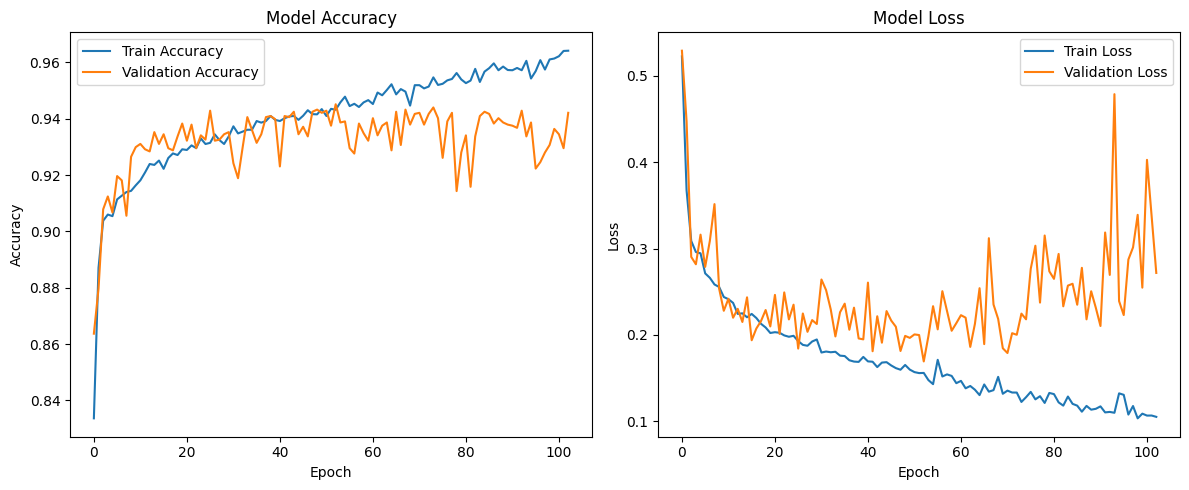

Miglior accuracy: 0.9452 (epoch 53)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.78      0.64      0.70        22
           C       0.90      0.98      0.94      1177
           M       0.98      0.97      0.97        58
        None       1.00      0.98      0.99      1213
           T       0.64      0.28      0.39       156

    accuracy                           0.94      2626
   macro avg       0.86      0.77      0.80      2626
weighted avg       0.93      0.94      0.93      2626



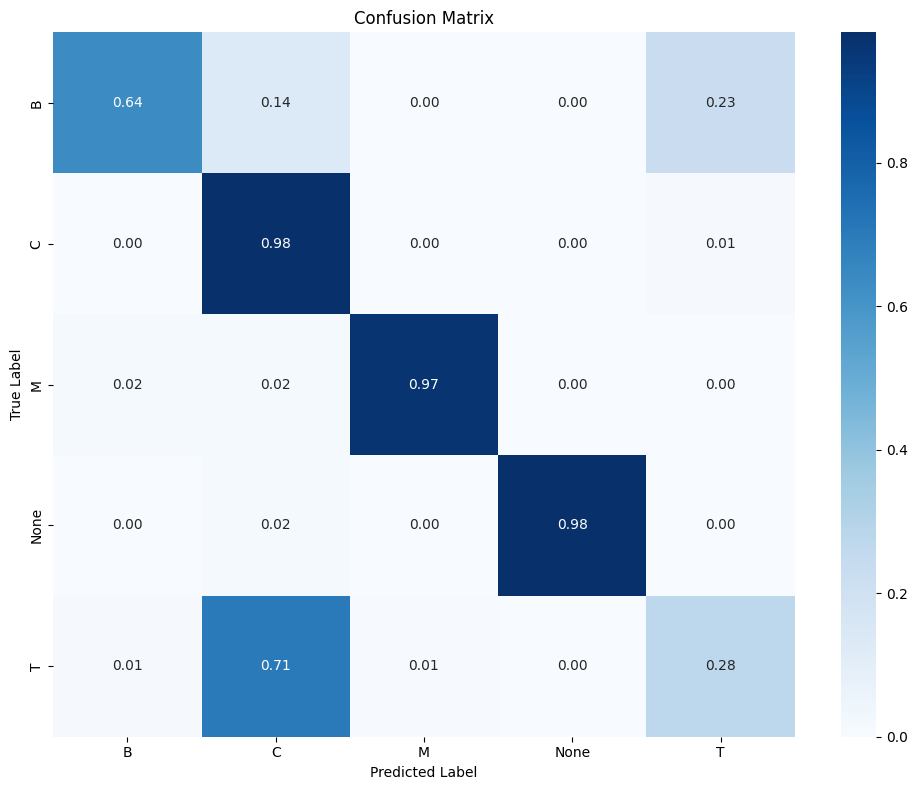


===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Vehicle accuracy: 0.9364
Test loss: 0.2080
Test accuracy: 0.9364

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.78      0.64      0.70        22
           C       0.90      0.98      0.94      1177
           M       0.98      0.97      0.97        58
        None       1.00      0.98      0.99      1213
           T       0.64      0.28      0.39       156

    accuracy                           0.94      2626
   macro avg       0.86      0.77      0.80      2626
weighted avg       0.93      0.94      0.93      2626



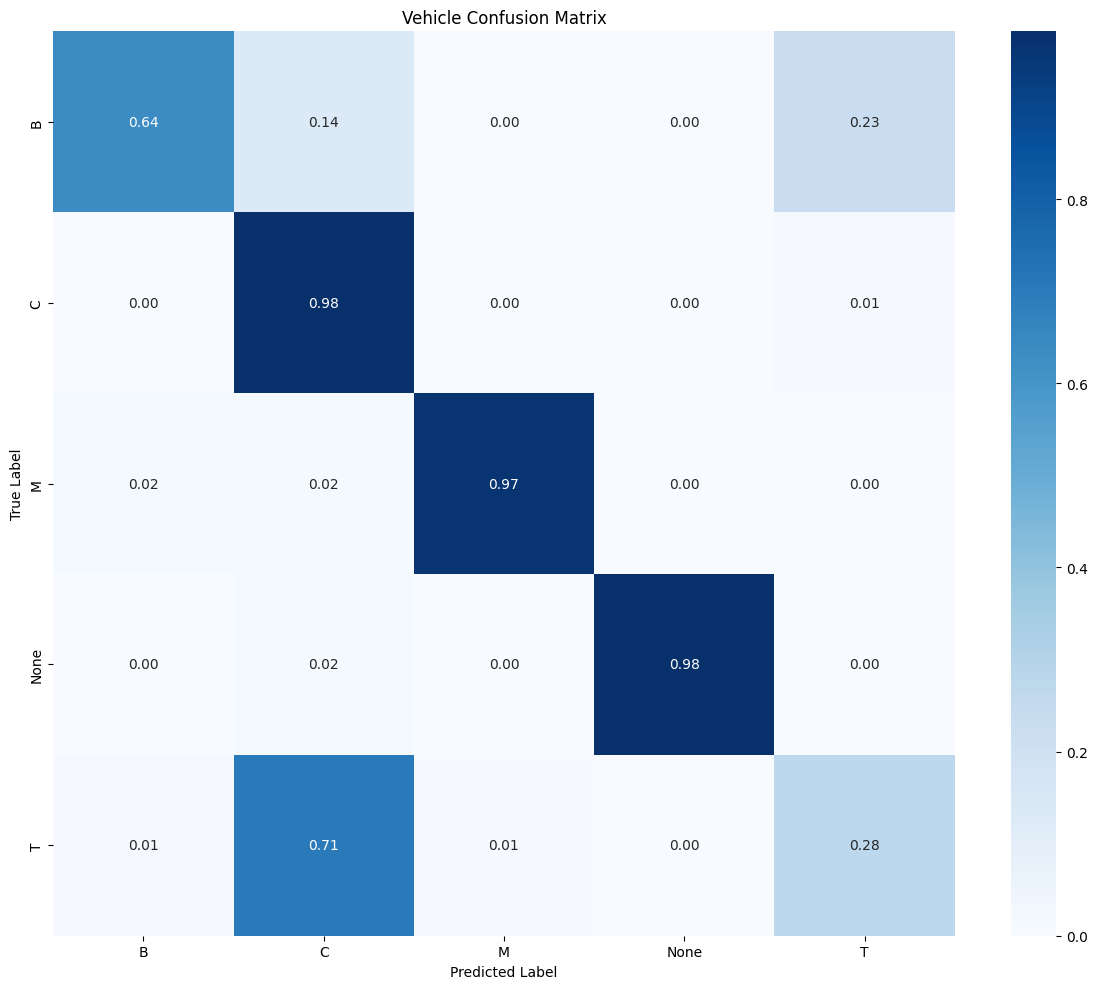


Balanced accuracy score: 0.7681


In [10]:
# STAMPE RISULTATI
plot_single_output_model(
    history_13, 
    y_true_13, 
    y_pred_13, 
    class_names=le_vehicle.classes_
)

plot_vehicle_test_results(
    y_true_13, 
    y_pred_13, 
    le_vehicle.classes_,
    test_results=(test_loss_13, test_acc_13)
)

In [11]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 14
# ------------------------------------------------------------------------------

'''
PARTE DIRECTION

Come modello 9 ma con data aug
'''

# Definizione del modello

# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(direction_features_scaled.shape[1],), name='direction_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.2)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(x2)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

output = tf.keras.layers.Dense(3, activation='softmax')(x)

# Modello completo
model_14 = tf.keras.Model(inputs=input_features, outputs=output)

model_14.summary()


model_14.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_vehicle_output_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_14.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ direction_features_input        │ (None, 8)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 631,459 (2.41 MB)

 Trainable params: 631,459 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history_14 = model_14.fit(
    direction_features_train,  # inputs
    y_train_direction,         # target - direction labels, not vehicle
    epochs=500,
    batch_size=32,
    validation_data=(direction_features_val, y_val_direction),
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/500
377/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5236 - loss: 0.9513

c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_vehicle_output_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5243 - loss: 0.9501 - val_accuracy: 0.6329 - val_loss: 0.7791 - learning_rate: 0.0010
Epoch 2/500
370/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6117 - loss: 0.7799

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6118 - loss: 0.7797 - val_accuracy: 0.6550 - val_loss: 0.7057 - learning_rate: 0.0010
Epoch 3/500
370/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6346 - loss: 0.7357

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6348 - loss: 0.7356 - val_accuracy: 0.6828 - val_loss: 0.6700 - learning_rate: 0.0010
Epoch 4/500
368/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6616 - loss: 0.7044

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6616 - loss: 0.7043 - val_accuracy: 0.6992 - val_loss: 0.6559 - learning_rate: 0.0010
Epoch 5/500
381/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6720 - loss: 0.6680

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6720 - loss: 0.6681 - val_accuracy: 0.6912 - val_loss: 0.6534 - learning_rate: 0.0010
Epoch 6/500
368/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6887 - loss: 0.6640

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6886 - loss: 0.6641 - val_accuracy: 0.7190 - val_loss: 0.6210 - learning_rate: 0.0010
Epoch 7/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6954 - loss: 0.6480 - val_accuracy: 0.7182 - val_loss: 0.6360 - learning_rate: 0.0010
Epoch 8/500
370/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7004 - loss: 0.6440

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7003 - loss: 0.6441 - val_accuracy: 0.7178 - val_loss: 0.5944 - learning_rate: 0.0010
Epoch 9/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6963 - loss: 0.6400 - val_accuracy: 0.7201 - val_loss: 0.6047 - learning_rate: 0.0010
Epoch 10/500
372/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7071 - loss: 0.6232

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7070 - loss: 0.6233 - val_accuracy: 0.7289 - val_loss: 0.5791 - learning_rate: 0.0010
Epoch 11/500
376/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7075 - loss: 0.6218

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7076 - loss: 0.6218 - val_accuracy: 0.7342 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 12/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7083 - loss: 0.6237 - val_accuracy: 0.7262 - val_loss: 0.5872 - learning_rate: 0.0010
Epoch 13/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7267 - loss: 0.6022 - val_accuracy: 0.7407 - val_loss: 0.5770 - learning_rate: 0.0010
Epoch 14/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7203 - loss: 0.6038 - val_accuracy: 0.7479 - val_loss: 0.5815 - learning_rate: 0.0010
Epoch 15/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7173 - loss: 0.6059 - val_accuracy: 0.7285 - val_loss: 0.5807 - learning_rate: 0.0010
Epoch 16/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7279 - loss: 0.5929 - val_accuracy: 0.7376 - val_loss: 0.5807 - learning_rate: 0.0010
Epoch 17/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7219 - loss: 0.5977 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7205 - loss: 0.5958 - val_accuracy: 0.7376 - val_loss: 0.5718 - learning_rate: 0.0010
Epoch 19/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7227 - loss: 0.6068 - val_accuracy: 0.7296 - val_loss: 0.5817 - learning_rate: 0.0010
Epoch 20/500
375/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7348 - loss: 0.5862

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7347 - loss: 0.5863 - val_accuracy: 0.7342 - val_loss: 0.5649 - learning_rate: 0.0010
Epoch 21/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7286 - loss: 0.5856 - val_accuracy: 0.7319 - val_loss: 0.5656 - learning_rate: 0.0010
Epoch 22/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7361 - loss: 0.5813 - val_accuracy: 0.7106 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 23/500
381/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7263 - loss: 0.5820

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7263 - loss: 0.5820 - val_accuracy: 0.7494 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 24/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7270 - loss: 0.5860 - val_accuracy: 0.7399 - val_loss: 0.5668 - learning_rate: 0.0010
Epoch 25/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7300 - loss: 0.5853

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7300 - loss: 0.5853 - val_accuracy: 0.7487 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 26/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7360 - loss: 0.5714 - val_accuracy: 0.7327 - val_loss: 0.5747 - learning_rate: 0.0010
Epoch 27/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7330 - loss: 0.5800 - val_accuracy: 0.7281 - val_loss: 0.5696 - learning_rate: 0.0010
Epoch 28/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7309 - loss: 0.5770 - val_accuracy: 0.7414 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 29/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7296 - loss: 0.5830 - val_accuracy: 0.7342 - val_loss: 0.5748 - learning_rate: 0.0010
Epoch 30/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7404 - loss: 0.5710 - val_accuracy: 0.7258 - val_loss: 0.5643 - learning_rate: 0.0010
Epoch 31/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7287 - loss: 0.5787 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7453 - loss: 0.5648 - val_accuracy: 0.7506 - val_loss: 0.5527 - learning_rate: 0.0010
Epoch 38/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7443 - loss: 0.5610 - val_accuracy: 0.7521 - val_loss: 0.5529 - learning_rate: 0.0010
Epoch 39/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7359 - loss: 0.5689 - val_accuracy: 0.7464 - val_loss: 0.5588 - learning_rate: 0.0010
Epoch 40/500
377/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7400 - loss: 0.5647

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7401 - loss: 0.5647 - val_accuracy: 0.7449 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 41/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7487 - loss: 0.5488 - val_accuracy: 0.7445 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 42/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7333 - loss: 0.5733 - val_accuracy: 0.7487 - val_loss: 0.5540 - learning_rate: 0.0010
Epoch 43/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7313 - loss: 0.5711 - val_accuracy: 0.7460 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 44/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7460 - loss: 0.5527 - val_accuracy: 0.7510 - val_loss: 0.5503 - learning_rate: 0.0010
Epoch 45/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7455 - loss: 0.5627 - val_accuracy: 0.7517 - val_loss: 0.5559 - learning_rate: 0.0010
Epoch 46/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7480 - loss: 0.5469 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7532 - loss: 0.5443 - val_accuracy: 0.7540 - val_loss: 0.5468 - learning_rate: 0.0010
Epoch 49/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7457 - loss: 0.5563 - val_accuracy: 0.7376 - val_loss: 0.5547 - learning_rate: 0.0010
Epoch 50/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7481 - loss: 0.5545 - val_accuracy: 0.7452 - val_loss: 0.5612 - learning_rate: 0.0010
Epoch 51/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7527 - loss: 0.5454 - val_accuracy: 0.7395 - val_loss: 0.5578 - learning_rate: 0.0010
Epoch 52/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7515 - loss: 0.5535 - val_accuracy: 0.7487 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 53/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7469 - loss: 0.5519 - val_accuracy: 0.7540 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 54/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7485 - loss: 0.5558 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7557 - loss: 0.5404 - val_accuracy: 0.7582 - val_loss: 0.5393 - learning_rate: 0.0010
Epoch 59/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7430 - loss: 0.5560 - val_accuracy: 0.7460 - val_loss: 0.5526 - learning_rate: 0.0010
Epoch 60/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7527 - loss: 0.5417 - val_accuracy: 0.7460 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 61/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7542 - loss: 0.5443 - val_accuracy: 0.7399 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 62/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7478 - loss: 0.5502 - val_accuracy: 0.7612 - val_loss: 0.5396 - learning_rate: 0.0010
Epoch 63/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7466 - loss: 0.5531 - val_accuracy: 0.7449 - val_loss: 0.5556 - learning_rate: 0.0010
Epoch 64/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7523 - loss: 0.5433 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7503 - loss: 0.5452 - val_accuracy: 0.7620 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 69/500
371/383 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7530 - loss: 0.5378

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7529 - loss: 0.5380 - val_accuracy: 0.7620 - val_loss: 0.5371 - learning_rate: 0.0010
Epoch 70/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7571 - loss: 0.5417 - val_accuracy: 0.7517 - val_loss: 0.5506 - learning_rate: 0.0010
Epoch 71/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7504 - loss: 0.5452 - val_accuracy: 0.7559 - val_loss: 0.5505 - learning_rate: 0.0010
Epoch 72/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7517 - loss: 0.5353 - val_accuracy: 0.7551 - val_loss: 0.5466 - learning_rate: 0.0010
Epoch 73/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7557 - loss: 0.5372 - val_accuracy: 0.7475 - val_loss: 0.5462 - learning_rate: 0.0010
Epoch 74/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7629 - loss: 0.5335 - val_accuracy: 0.7521 - val_loss: 0.5453 - learning_rate: 0.0010
Epoch 75/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7589 - loss: 0.5328 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7567 - loss: 0.5351 - val_accuracy: 0.7570 - val_loss: 0.5364 - learning_rate: 0.0010
Epoch 88/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7572 - loss: 0.5342 - val_accuracy: 0.7551 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 89/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7559 - loss: 0.5305 - val_accuracy: 0.7593 - val_loss: 0.5400 - learning_rate: 0.0010
Epoch 90/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7558 - loss: 0.5412 - val_accuracy: 0.7525 - val_loss: 0.5484 - learning_rate: 0.0010
Epoch 91/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7497 - loss: 0.5557 - val_accuracy: 0.7536 - val_loss: 0.5403 - learning_rate: 0.0010
Epoch 92/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7478 - loss: 0.5449 - val_accuracy: 0.7506 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 93/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7619 - loss: 0.5261 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7525 - loss: 0.5346 - val_accuracy: 0.7586 - val_loss: 0.5327 - learning_rate: 0.0010
Epoch 100/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7578 - loss: 0.5229 - val_accuracy: 0.7490 - val_loss: 0.5389 - learning_rate: 0.0010
Epoch 101/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7605 - loss: 0.5260 - val_accuracy: 0.7551 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 102/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7563 - loss: 0.5354 - val_accuracy: 0.7563 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 103/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7586 - loss: 0.5265 - val_accuracy: 0.7391 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 104/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7599 - loss: 0.5300 - val_accuracy: 0.7437 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 105/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7586 - loss: 0.

In [13]:
# TEST
best_model_14 = tf.keras.models.load_model('best_model_14.h5')

test_loss_14, test_acc_14 = model_14.evaluate(direction_features_test, y_test_direction, verbose=1)
print(f"\nTest accuracy: {test_acc_14:.4f}")
print(f"Test loss: {test_loss_14:.4f}")

y_pred_prob_14 = model_14.predict(direction_features_test)
y_pred_14 = np.argmax(y_pred_prob_14, axis=1)
y_true_14 = np.argmax(y_test_direction, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7693 - loss: 0.5124

Test accuracy: 0.7681
Test loss: 0.5304
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


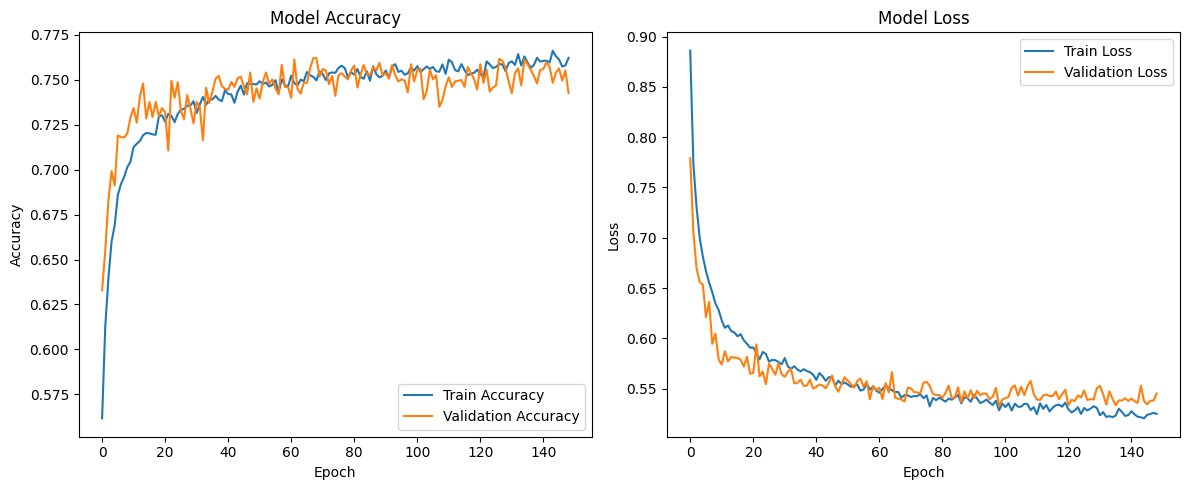

Miglior accuracy: 0.7620 (epoch 68)

--- Classification Report ---
              precision    recall  f1-score   support

           L       0.66      0.58      0.62       715
        None       0.90      0.90      0.90      1213
           R       0.65      0.72      0.69       698

    accuracy                           0.77      2626
   macro avg       0.74      0.74      0.74      2626
weighted avg       0.77      0.77      0.77      2626



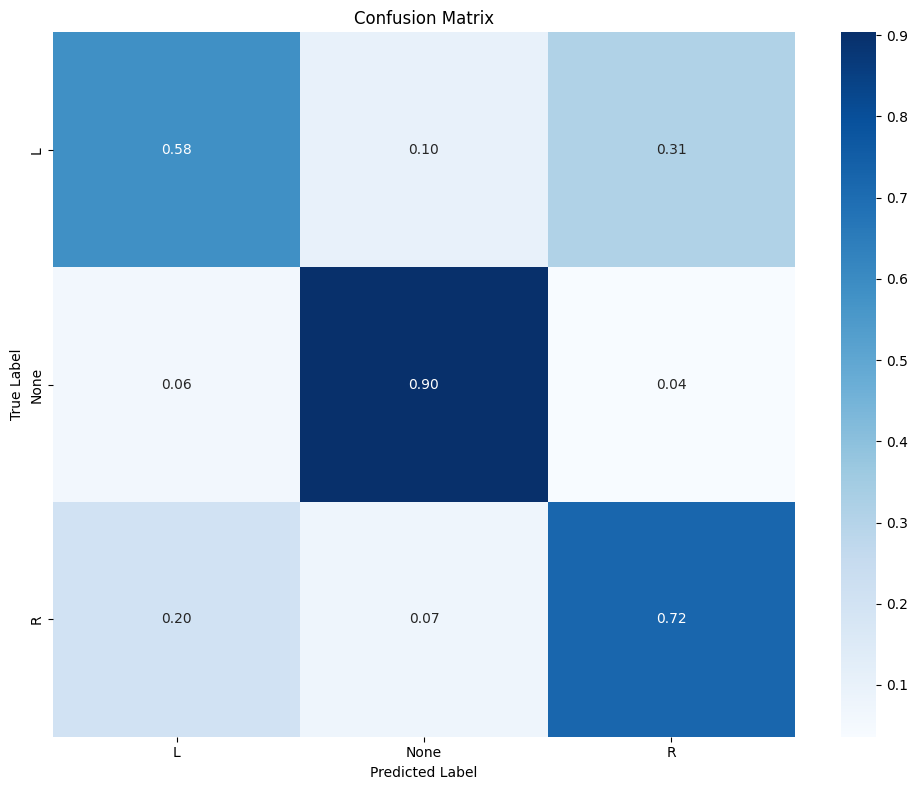


===== RISULTATI CLASSIFICAZIONE DIREZIONI =====
Direction accuracy: 0.7681
Test loss: 0.5304
Test accuracy: 0.7681

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.66      0.58      0.62       715
        None       0.90      0.90      0.90      1213
           R       0.65      0.72      0.69       698

    accuracy                           0.77      2626
   macro avg       0.74      0.74      0.74      2626
weighted avg       0.77      0.77      0.77      2626



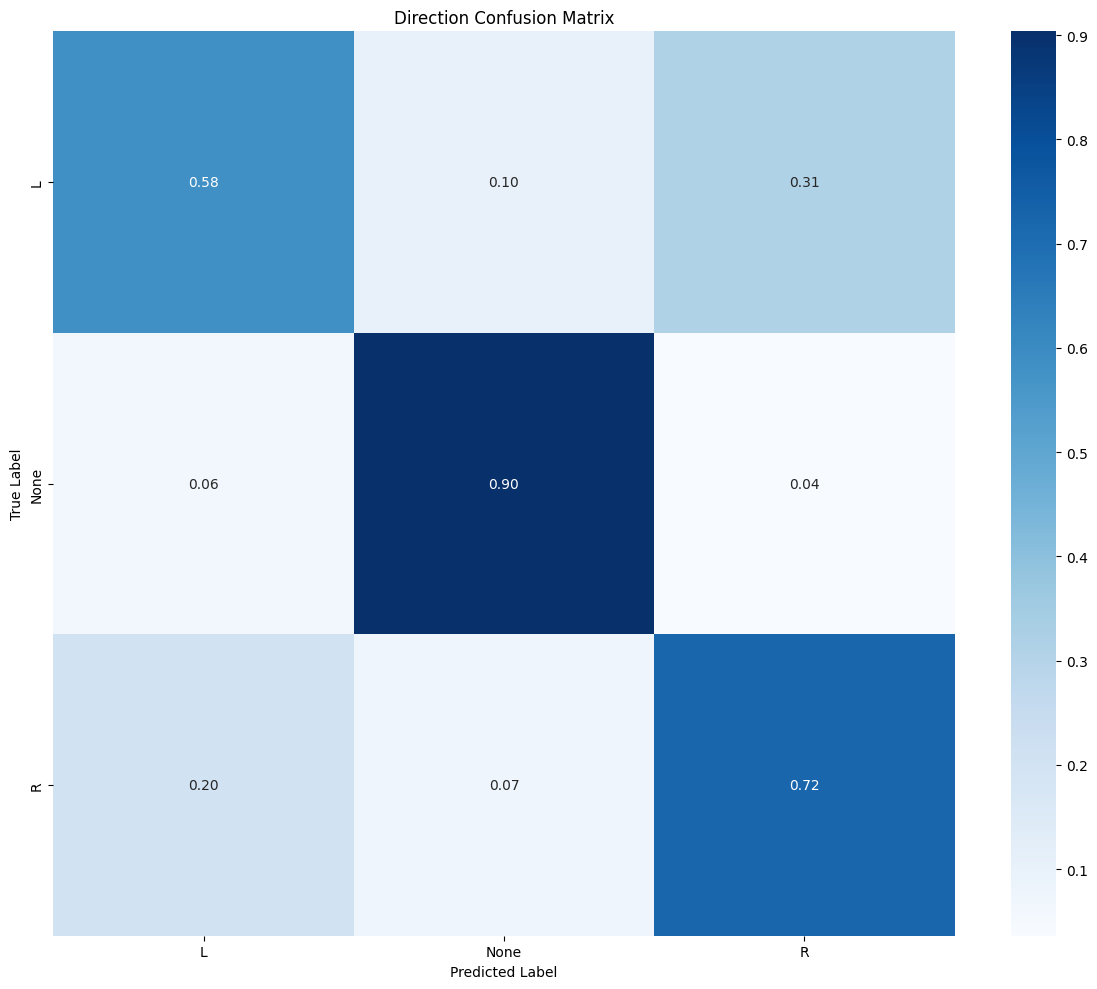


Balanced accuracy score: 0.7363


In [14]:
# STAMPE RISULTATI
plot_single_output_model(
    history_14, 
    y_true_14, 
    y_pred_14, 
    class_names=le_direction.classes_
)

plot_direction_test_results(
    y_true_14, 
    y_pred_14, 
    le_direction.classes_,
    test_results=(test_loss_14, test_acc_14)
)

In [15]:
audio_and_direction_features = np.concatenate([
    centroid_stats,                     # (17506, 4)
    rolloff_stats,                      # (17506, 4) 
    contrast_stats_left,                # (17506, 4)
    contrast_stats_right,               # (17506, 4)
    low_freq_energies.reshape(-1, 1),   # (17506, 1)
    ild_features,                       # (17506, 4)
    ipd_features                        # (17506, 4) 
], axis=1)  # Risultato: (17506, 25)

# "Cleaning"
audio_and_direction_features = np.nan_to_num(audio_and_direction_features, nan=0.0, posinf=0.0, neginf=0.0)

# Normalize
scaler = StandardScaler()
audio_and_direction_features_scaled = scaler.fit_transform(audio_and_direction_features)

print()
print(audio_and_direction_features_scaled.shape)


(17506, 25)


In [18]:
# ------------------------------------------------------------------------------
# DATASET SPLIT
# ------------------------------------------------------------------------------

print(f"Dimensione spettrogrammi prima del reshape: {spectrograms.shape}")
spectrograms_reshaped = spectrograms.transpose(0, 2, 3, 1)  # (17506, 128, 188, 2)
print(f"Dimensione spettrogrammi dopo il reshape: {spectrograms_reshaped.shape}")

# 1. Primo split: Train (70%) e Temporary (30%)
X_train, X_temp, audio_features_train, audio_features_temp, direction_features_train, direction_features_temp, audio_and_direction_features_train, audio_and_direction_features_temp, y_train_vehicle, y_temp_vehicle, y_train_direction, y_temp_direction = train_test_split(
    spectrograms_reshaped,
    audio_features_scaled,
    direction_features_scaled,
    audio_and_direction_features_scaled,
    labels_cat_vehicles,
    labels_cat_direction,
    test_size=0.30,         # 70% train, 30% temporary
    random_state=42,
    shuffle=True
)

# 2. Secondo split: Temporary in Validation (15%) e Test (15%)
X_val, X_test, audio_features_val, audio_features_test, direction_features_val, direction_features_test, audio_and_direction_features_val, audio_and_direction_features_test, y_val_vehicle, y_test_vehicle, y_val_direction, y_test_direction = train_test_split(
    X_temp,
    audio_features_temp,
    direction_features_temp,
    audio_and_direction_features_temp,
    y_temp_vehicle,
    y_temp_direction,
    test_size=0.50,        # 15% validation, 15% test (metà del 30% temporary)
    random_state=42,
    shuffle=True
)

print()
print(f"Train set: {len(X_train)} campioni")
print(f"Validation set: {len(X_val)} campioni")
print(f"Test set: {len(X_test)} campioni")

# Verifica dimensioni input per il modello
print(f"Dimensione input spettrogrammi: {X_train.shape[1:]}")
print(f"Dimensione input feature audio: {audio_features_train.shape[1:]}")
print(f"Dimensione input feature direzione: {direction_features_train.shape[1:]}")
print(f"Dimensione input feature combinate: {audio_and_direction_features_train.shape[1:]}")

Dimensione spettrogrammi prima del reshape: (17506, 2, 128, 188)
Dimensione spettrogrammi dopo il reshape: (17506, 128, 188, 2)

Train set: 12254 campioni
Validation set: 2626 campioni
Test set: 2626 campioni
Dimensione input spettrogrammi: (128, 188, 2)
Dimensione input feature audio: (17,)
Dimensione input feature direzione: (8,)
Dimensione input feature combinate: (25,)


In [19]:

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 15
# ------------------------------------------------------------------------------

'''
PARTE DIRECTION

Come modello 14 ma con anche le audio feature
'''

# Definizione del modello

# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_and_direction_features_scaled.shape[1],), name='audio_and_direction_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.2)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(x2)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

output = tf.keras.layers.Dense(3, activation='softmax')(x)

# Modello completo
model_15 = tf.keras.Model(inputs=input_features, outputs=output)

model_15.summary()


model_15.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_vehicle_output_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_15.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio_and_direction_features_i… │ (None, 25)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1024)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 632,547 (2.41 MB)

 Trainable params: 632,547 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_15 = model_15.fit(
    audio_and_direction_features_train,  # IMPORTANTE: usare le feature combinate qui
    y_train_direction,                   # target - direction labels, not vehicle
    epochs=500,
    batch_size=32,
    validation_data=(audio_and_direction_features_val, y_val_direction),
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/500
379/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5933 - loss: 0.8294

c:\Users\matte\miniconda3\envs\env_STMAE\lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_vehicle_output_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5938 - loss: 0.8283 - val_accuracy: 0.6866 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 2/500
376/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6599 - loss: 0.6388

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6601 - loss: 0.6386 - val_accuracy: 0.6938 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 3/500
378/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6864 - loss: 0.6218

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6864 - loss: 0.6214 - val_accuracy: 0.6889 - val_loss: 0.5444 - learning_rate: 0.0010
Epoch 4/500
379/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6941 - loss: 0.5737

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6941 - loss: 0.5737 - val_accuracy: 0.7148 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 5/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7034 - loss: 0.5574 - val_accuracy: 0.7414 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 6/500
374/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7133 - loss: 0.5496

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7134 - loss: 0.5495 - val_accuracy: 0.7471 - val_loss: 0.5090 - learning_rate: 0.0010
Epoch 7/500
377/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7224 - loss: 0.5303

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7224 - loss: 0.5304 - val_accuracy: 0.7589 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 8/500
381/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7311 - loss: 0.5283

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7311 - loss: 0.5282 - val_accuracy: 0.7601 - val_loss: 0.4988 - learning_rate: 0.0010
Epoch 9/500
372/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7372 - loss: 0.5224

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7372 - loss: 0.5224 - val_accuracy: 0.7654 - val_loss: 0.4981 - learning_rate: 0.0010
Epoch 10/500
377/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7450 - loss: 0.5154

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7449 - loss: 0.5154 - val_accuracy: 0.7662 - val_loss: 0.4895 - learning_rate: 0.0010
Epoch 11/500
376/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7465 - loss: 0.5051

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7464 - loss: 0.5050 - val_accuracy: 0.7700 - val_loss: 0.4690 - learning_rate: 0.0010
Epoch 12/500
380/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7491 - loss: 0.4965

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7491 - loss: 0.4965 - val_accuracy: 0.7688 - val_loss: 0.4656 - learning_rate: 0.0010
Epoch 13/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7547 - loss: 0.4850 - val_accuracy: 0.7757 - val_loss: 0.4699 - learning_rate: 0.0010
Epoch 14/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7673 - loss: 0.4820

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7673 - loss: 0.4821 - val_accuracy: 0.7807 - val_loss: 0.4545 - learning_rate: 0.0010
Epoch 15/500
379/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7658 - loss: 0.4776

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7658 - loss: 0.4776 - val_accuracy: 0.7879 - val_loss: 0.4454 - learning_rate: 0.0010
Epoch 16/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7714 - loss: 0.4750 - val_accuracy: 0.7966 - val_loss: 0.4579 - learning_rate: 0.0010
Epoch 17/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7743 - loss: 0.4536 - val_accuracy: 0.7803 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 18/500
378/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7645 - loss: 0.4819

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7646 - loss: 0.4817 - val_accuracy: 0.7963 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 19/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7751 - loss: 0.4599 - val_accuracy: 0.7841 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 20/500
374/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7752 - loss: 0.4665

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7752 - loss: 0.4664 - val_accuracy: 0.7913 - val_loss: 0.4423 - learning_rate: 0.0010
Epoch 21/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7809 - loss: 0.4548 - val_accuracy: 0.7814 - val_loss: 0.4465 - learning_rate: 0.0010
Epoch 22/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7951 - loss: 0.4443 - val_accuracy: 0.7913 - val_loss: 0.4484 - learning_rate: 0.0010
Epoch 23/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7851 - loss: 0.4526 - val_accuracy: 0.7898 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 24/500
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7826 - loss: 0.4515

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7826 - loss: 0.4515 - val_accuracy: 0.7902 - val_loss: 0.4358 - learning_rate: 0.0010
Epoch 25/500
375/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7832 - loss: 0.4436

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7832 - loss: 0.4436 - val_accuracy: 0.7829 - val_loss: 0.4293 - learning_rate: 0.0010
Epoch 26/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7845 - loss: 0.4499 - val_accuracy: 0.7841 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 27/500
379/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7908 - loss: 0.4418

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7908 - loss: 0.4419 - val_accuracy: 0.7909 - val_loss: 0.4207 - learning_rate: 0.0010
Epoch 28/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7911 - loss: 0.4354 - val_accuracy: 0.7917 - val_loss: 0.4354 - learning_rate: 0.0010
Epoch 29/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7882 - loss: 0.4393 - val_accuracy: 0.7951 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 30/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7889 - loss: 0.4355 - val_accuracy: 0.7944 - val_loss: 0.4311 - learning_rate: 0.0010
Epoch 31/500
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8006 - loss: 0.4349

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8006 - loss: 0.4349 - val_accuracy: 0.8062 - val_loss: 0.4085 - learning_rate: 0.0010
Epoch 32/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7944 - loss: 0.4380

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7944 - loss: 0.4380 - val_accuracy: 0.8005 - val_loss: 0.4076 - learning_rate: 0.0010
Epoch 33/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7929 - loss: 0.4292 - val_accuracy: 0.7852 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 34/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7904 - loss: 0.4344 - val_accuracy: 0.7932 - val_loss: 0.4251 - learning_rate: 0.0010
Epoch 35/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7943 - loss: 0.4286 - val_accuracy: 0.7963 - val_loss: 0.4286 - learning_rate: 0.0010
Epoch 36/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7983 - loss: 0.4238 - val_accuracy: 0.8008 - val_loss: 0.4177 - learning_rate: 0.0010
Epoch 37/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8022 - loss: 0.4174 - val_accuracy: 0.8046 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 38/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7938 - loss: 0.4273 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7990 - loss: 0.4130 - val_accuracy: 0.8085 - val_loss: 0.4074 - learning_rate: 0.0010
Epoch 48/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8082 - loss: 0.4064 - val_accuracy: 0.7997 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 49/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8053 - loss: 0.4082 - val_accuracy: 0.7951 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 50/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8009 - loss: 0.4213 - val_accuracy: 0.8043 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 51/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8106 - loss: 0.4005 - val_accuracy: 0.7887 - val_loss: 0.4254 - learning_rate: 0.0010
Epoch 52/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8124 - loss: 0.3962 - val_accuracy: 0.8035 - val_loss: 0.4094 - learning_rate: 0.0010
Epoch 53/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8059 - loss: 0.4124 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8133 - loss: 0.3952 - val_accuracy: 0.8050 - val_loss: 0.4068 - learning_rate: 0.0010
Epoch 63/500
381/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8122 - loss: 0.3957

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8122 - loss: 0.3957 - val_accuracy: 0.8035 - val_loss: 0.4042 - learning_rate: 0.0010
Epoch 64/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8176 - loss: 0.3943 - val_accuracy: 0.8016 - val_loss: 0.4116 - learning_rate: 0.0010
Epoch 65/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8178 - loss: 0.3965 - val_accuracy: 0.8065 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 66/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8046 - loss: 0.4103 - val_accuracy: 0.8020 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 67/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8107 - loss: 0.3995 - val_accuracy: 0.8039 - val_loss: 0.4073 - learning_rate: 0.0010
Epoch 68/500
381/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8155 - loss: 0.3908

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8155 - loss: 0.3908 - val_accuracy: 0.8046 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 69/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8177 - loss: 0.3990 - val_accuracy: 0.8134 - val_loss: 0.4110 - learning_rate: 0.0010
Epoch 70/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8220 - loss: 0.3918 - val_accuracy: 0.7993 - val_loss: 0.4125 - learning_rate: 0.0010
Epoch 71/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8063 - loss: 0.4048

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8063 - loss: 0.4047 - val_accuracy: 0.8073 - val_loss: 0.4014 - learning_rate: 0.0010
Epoch 72/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8127 - loss: 0.3896 - val_accuracy: 0.8126 - val_loss: 0.4037 - learning_rate: 0.0010
Epoch 73/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8174 - loss: 0.3890 - val_accuracy: 0.8069 - val_loss: 0.4070 - learning_rate: 0.0010
Epoch 74/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8209 - loss: 0.3934 - val_accuracy: 0.8085 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 75/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8154 - loss: 0.3967 - val_accuracy: 0.8123 - val_loss: 0.4016 - learning_rate: 0.0010
Epoch 76/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8187 - loss: 0.3892 - val_accuracy: 0.8138 - val_loss: 0.4092 - learning_rate: 0.0010
Epoch 77/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8163 - loss: 0.3870 -

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8199 - loss: 0.3925 - val_accuracy: 0.8104 - val_loss: 0.3983 - learning_rate: 0.0010
Epoch 98/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8200 - loss: 0.3747 - val_accuracy: 0.8073 - val_loss: 0.4026 - learning_rate: 0.0010
Epoch 99/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8206 - loss: 0.3861 - val_accuracy: 0.8035 - val_loss: 0.4125 - learning_rate: 0.0010
Epoch 100/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8283 - loss: 0.3738 - val_accuracy: 0.8073 - val_loss: 0.4133 - learning_rate: 0.0010
Epoch 101/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8265 - loss: 0.3878 - val_accuracy: 0.8058 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 102/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8197 - loss: 0.3765 - val_accuracy: 0.7986 - val_loss: 0.4105 - learning_rate: 0.0010
Epoch 103/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8216 - loss: 0.38

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8326 - loss: 0.3718 - val_accuracy: 0.8168 - val_loss: 0.3978 - learning_rate: 0.0010
Epoch 111/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8311 - loss: 0.3675 - val_accuracy: 0.8123 - val_loss: 0.4043 - learning_rate: 0.0010
Epoch 112/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8272 - loss: 0.3742 - val_accuracy: 0.8081 - val_loss: 0.4038 - learning_rate: 0.0010
Epoch 113/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8283 - loss: 0.3708 - val_accuracy: 0.8126 - val_loss: 0.4030 - learning_rate: 0.0010
Epoch 114/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8224 - loss: 0.3765 - val_accuracy: 0.8054 - val_loss: 0.4156 - learning_rate: 0.0010
Epoch 115/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8263 - loss: 0.3770 - val_accuracy: 0.8024 - val_loss: 0.4179 - learning_rate: 0.0010
Epoch 116/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8271 - loss: 0.

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8291 - loss: 0.3693 - val_accuracy: 0.8111 - val_loss: 0.3943 - learning_rate: 0.0010
Epoch 128/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8278 - loss: 0.3679 - val_accuracy: 0.8172 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 129/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8265 - loss: 0.3703 - val_accuracy: 0.8100 - val_loss: 0.4074 - learning_rate: 0.0010
Epoch 130/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8311 - loss: 0.3655 - val_accuracy: 0.8111 - val_loss: 0.4044 - learning_rate: 0.0010
Epoch 131/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8253 - loss: 0.3780 - val_accuracy: 0.8107 - val_loss: 0.3966 - learning_rate: 0.0010
Epoch 132/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8282 - loss: 0.3643 - val_accuracy: 0.8126 - val_loss: 0.4052 - learning_rate: 0.0010
Epoch 133/500
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8245 - loss: 0.

In [21]:
# TEST
best_model_15 = tf.keras.models.load_model('best_model_15.h5')

test_loss_15, test_acc_15 = model_15.evaluate(audio_and_direction_features_test, y_test_direction, verbose=1)
print(f"\nTest accuracy: {test_acc_15:.4f}")
print(f"Test loss: {test_loss_15:.4f}")

y_pred_prob_15 = model_15.predict(audio_and_direction_features_test)
y_pred_15 = np.argmax(y_pred_prob_15, axis=1)
y_true_15 = np.argmax(y_test_direction, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8348 - loss: 0.3810

Test accuracy: 0.8225
Test loss: 0.3915
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


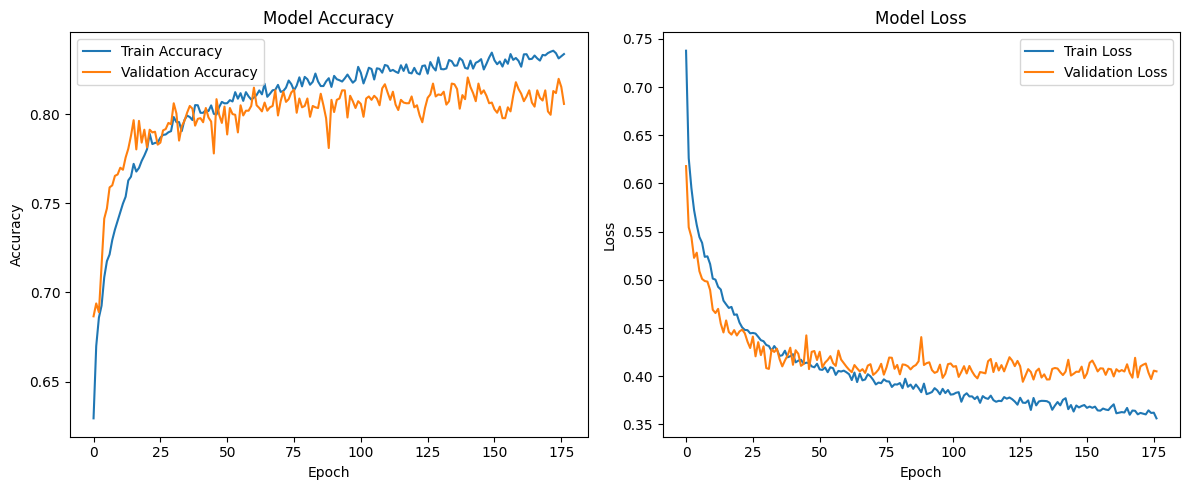

Miglior accuracy: 0.8206 (epoch 141)

--- Classification Report ---
              precision    recall  f1-score   support

           L       0.70      0.72      0.71       715
        None       0.96      0.97      0.96      1213
           R       0.71      0.67      0.69       698

    accuracy                           0.82      2626
   macro avg       0.79      0.79      0.79      2626
weighted avg       0.82      0.82      0.82      2626



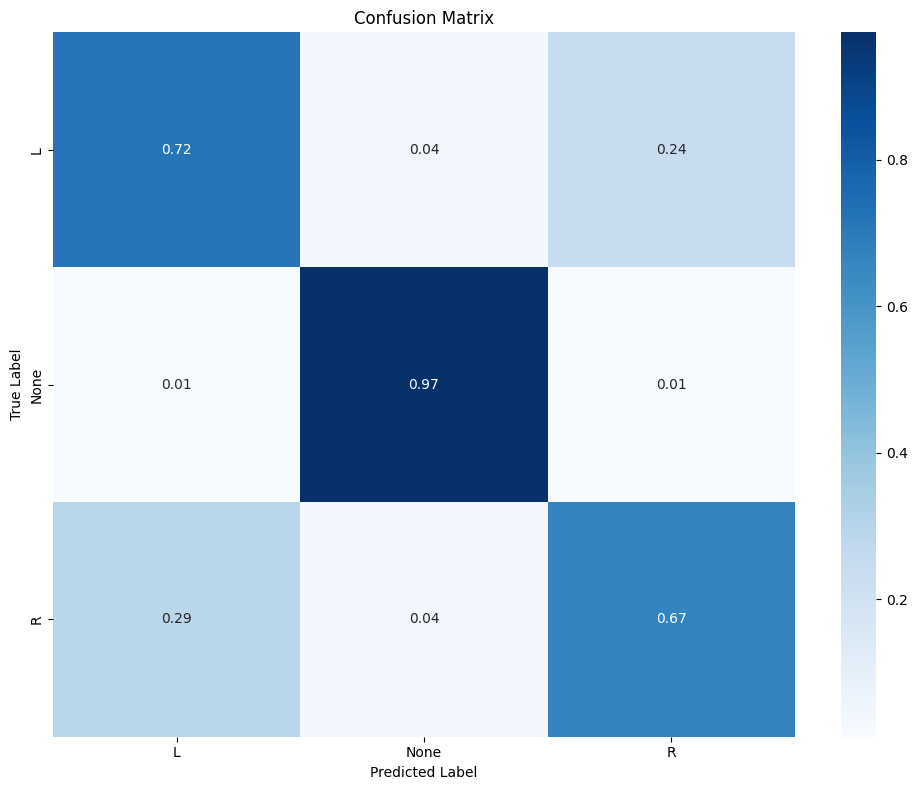


===== RISULTATI CLASSIFICAZIONE DIREZIONI =====
Direction accuracy: 0.8225
Test loss: 0.3915
Test accuracy: 0.8225

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.70      0.72      0.71       715
        None       0.96      0.97      0.96      1213
           R       0.71      0.67      0.69       698

    accuracy                           0.82      2626
   macro avg       0.79      0.79      0.79      2626
weighted avg       0.82      0.82      0.82      2626



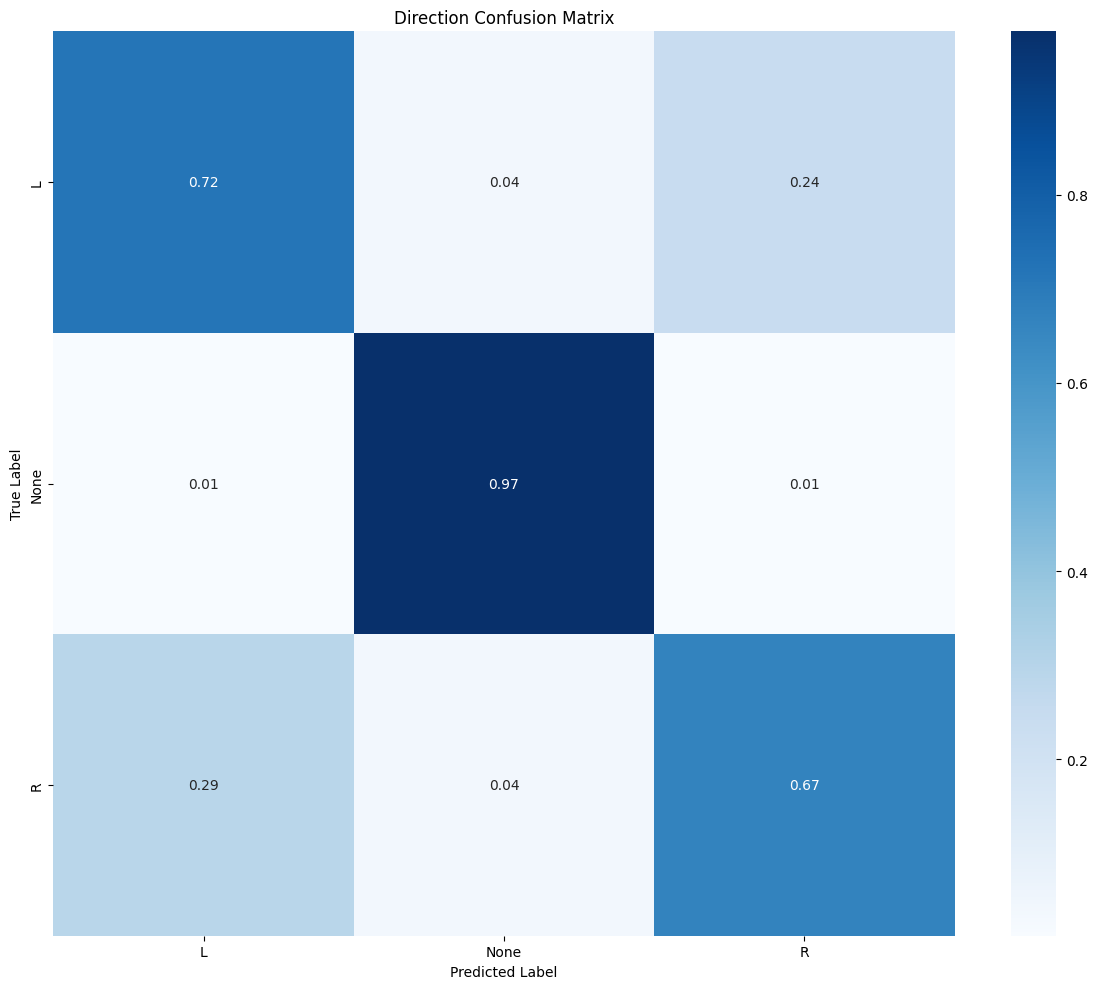


Balanced accuracy score: 0.7862


In [22]:
# STAMPE RISULTATI
plot_single_output_model(
    history_15, 
    y_true_15, 
    y_pred_15, 
    class_names=le_direction.classes_
)

plot_direction_test_results(
    y_true_15, 
    y_pred_15, 
    le_direction.classes_,
    test_results=(test_loss_15, test_acc_15)
)